In [1]:
import sys
import numpy as np
from scipy import linalg as la, optimize as opt
import matplotlib.pyplot as plt
import proplot as plot
from tqdm import tqdm

sys.path.append('/Users/46h/Research/code/accphys')
from tools.matrix_lattice import fodo
from tools.envelope_analysis import Envelope
from tools.utils import show
from tools import plotting as myplt

In [2]:
plot.rc['figure.facecolor'] = 'white'

# 4D Beam Covariance Matrix Reconstruction

In this notebook we will use transfer matrices to demonstrate the method outlined in [this paper](https://journals.aps.org/prab/pdf/10.1103/PhysRevSTAB.17.052801) to reconstruct the transverse beam covariance matrix. 

## Method description 

The method uses a wire-scanner at a single location. By wire-scanner, we mean a horizontal, vertical and diagonal wire which can measure the $\langle{x^2}\rangle$, $\langle{y^2}\rangle$, and $\langle{xy}\rangle$ moments. The wire-scanner is located at position $s$, and we want to measure the beam at an upstream location $s0$. We then vary one or more quadrupoles between $s0$ and $s$, each time measuring the beam dimensions at $s$. We call each measurement a *scan index* and the entire series of measurements a $scan$. 

Assuming no space charge, we know linear transfer matrix $M$ between $s_0$ and $s$. Then we also know the connection between the covariance matrix $\Sigma$ at the two points: $\Sigma_s = M \Sigma_{s_0} M^T$. This gives

$$\begin{align}
    \langle{x^2}\rangle_s &= 
        M_{11}^2\langle{x^2}\rangle_{s0} 
      + M_{12}^2\langle{x'^2}\rangle_{s0} 
      + 2M_{11}M_{22}\langle{xx'}\rangle_{s0} ,\\
    \langle{y^2}\rangle_s &= 
        M_{33}^2\langle{y^2}\rangle_{s0} 
      + M_{34}^2\langle{y'^2}\rangle_{s0} 
      + 2M_{33}M_{34}\langle{yy'}\rangle_{s0} ,\\
    \langle{xy}\rangle_s &= 
        M_{11}M_{33}\langle{xy}\rangle_{s0} 
      + M_{12}M_{33}\langle{yx'}\rangle_{s0} 
      + M_{11}M_{34}\langle{xy'}\rangle_{s0} 
      + M_{12}M_{34}\langle{x'y'}\rangle_{s0} .
\end{align}$$

The strategy is to take $N$ measurements, giving the following system of equations:

$$\begin{align}
    \mathbf{A \sigma} = \mathbf{b}.
\end{align}$$

where $\mathbf{b}$ is a vector of the $3N$ measurments, $\mathbf{A}$ is a $3N \times 10$ matrix, and $\mathbf{\sigma} = 
\left[{
    \langle{x^2}\rangle, \langle{x'^2}\rangle, \langle{xx'}\rangle,
    \langle{y^2}\rangle, \langle{y'^2}\rangle, \langle{yy'}\rangle,
    \langle{xy}\rangle,  \langle{yx'}\rangle,  \langle{xy'}\rangle, \langle{x'y'}\rangle,
}\right]_{s0}^T$. The system of equations is overdetermined, so we find the least-squares solution for $\mathbf{\sigma}$.

In [3]:
def get_mat(sigma):
    s11, s22, s12, s33, s44, s34, s13, s23, s14, s24 = sigma
    return np.array([[s11, s12, s13, s14], 
                     [s12, s22, s23, s24], 
                     [s13, s23, s33, s34], 
                     [s14, s24, s34, s44]])

def get_vec(Sigma):
    s11, s12, s13, s14 = Sigma[0, :]
    s22, s23, s24 = Sigma[1, 1:]
    s33, s34 = Sigma[2, 2:]
    s44 = Sigma[3, 3]
    return np.array([s11, s22, s12, s33, s44, s34, s13, s23, s14, s24])

## Implementation with transfer matrices 

We will create a lattice consisting of: half-drift, focusing quad, drift, defocusing quad, half-drift. The reconstruction point $s_0$ will be at the lattice entrance, and the measurement point $s$ will be at the lattice exit. We will track the envelope of a Danilov distribution without space charge, launching the same beam on each scan but changing the strength of the quadrupoles. First let's create the lattice.

In [26]:
k1, k2 = (0.5, 0.5)
length = 5.0
lattice = fodo(k1, k2, length, start='drift')

Create an envelope matched to this lattice in the 2D sense.

In [27]:
env = Envelope(eps=25)
env.match_bare(lattice.M, method='2D')

init_params = np.copy(env.params)
Sigma0 = env.cov()
sigma0 = get_vec(Sigma0)
show(Sigma0, 'Covariance matrix at s0')

Covariance matrix at s0 =
⎡52.521  19.622    0.0     12.5  ⎤
⎢                                ⎥
⎢19.622  10.306   -12.5    9.34  ⎥
⎢                                ⎥
⎢ 0.0    -12.5   52.521   -19.622⎥
⎢                                ⎥
⎣ 12.5    9.34   -19.622  10.306 ⎦


Choose the quadrupole strengths at each scan index.

In [6]:
def get_kvals(kmin, kmax, nscans):
    """Return quadrupole strengths at each scan index. 
    
    We linearly increase k1 (focusing quad) in the first half of the scan while 
    keeping k2 (defocusing quad) constant. This is flipped in the second half. 
    The strengths are measured in m^-2.
    """
    kavg = 0.5*(kmin + kmax)
    k1vals, k2vals = np.full(nscans, kavg), np.full(nscans, kavg)
    i = nscans // 2
    linear_scan = np.linspace(kmin, kmax, i)
    k1vals[:i] = linear_scan
    if nscans % 2 != 0:
        i += 1
    k2vals[i:] = linear_scan
    return k1vals, k2vals

In [28]:
nscans = 50
kmin, kmax = (0.4, 0.6)
k1vals, k2vals = get_kvals(kmin, kmax, nscans)

Construct $\mathbf{A}$ and $\mathbf{b}$.

In [29]:
def scan(init_params, kmin, kmax, nscans=3):
    """Take measurements and set up linear system of equations 
    
    The equations take the form Ax = b; we return A and b.
    """
    A, b = [], []
    env.params = init_params
    for (k1, k2) in zip(*get_kvals(kmin, kmax, nscans)):
        # Get transfer matrix
        lattice = fodo(k1, k2, length, start='drift')
        M = lattice.M
        A.append([M[0, 0]**2, M[0, 1]**2, M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
        A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, M[2, 2]*M[2, 3], 0, 0, 0, 0])
        A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
        # Take measurements
        env.params = init_params
        env.track(lattice.M)
        Sigma = env.cov()
        b.append(Sigma[0, 0])
        b.append(Sigma[2, 2])
        b.append(Sigma[0, 2])
    return np.array(A), np.array(b)

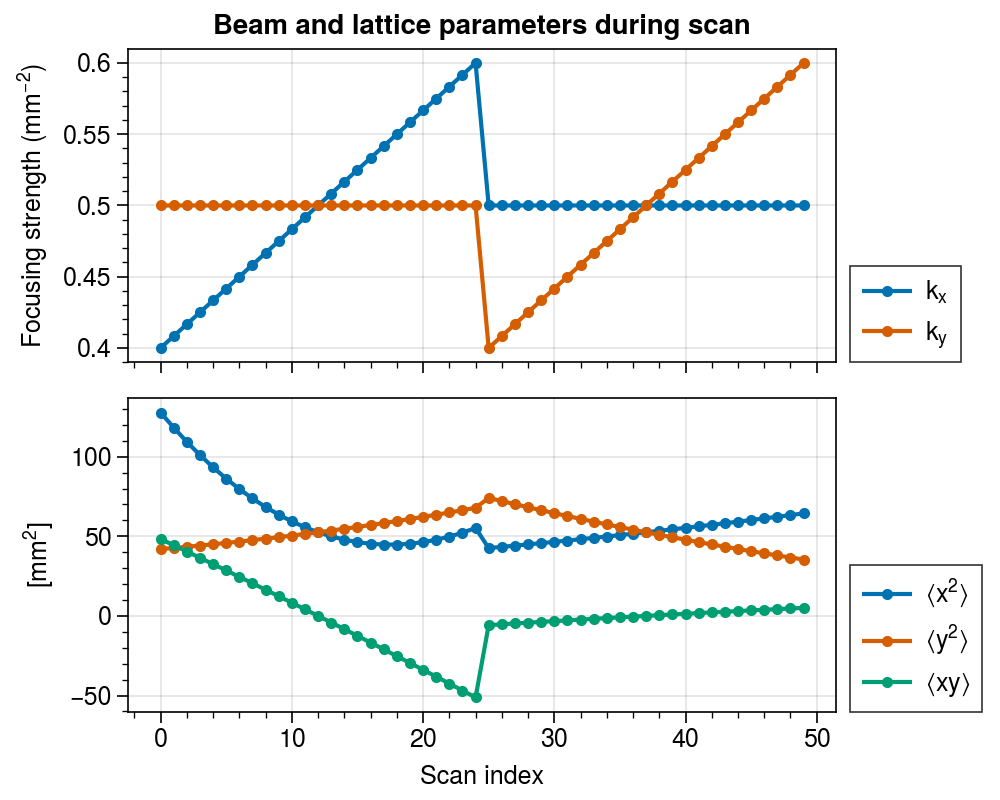

In [30]:
A, b = scan(env.params, kmin, kmax, nscans)

fig, axes = plot.subplots(nrows=2, figsize=(5, 4), spany=False)
axes[0].plot(k1vals, marker='.')
axes[0].plot(k2vals, marker='.')
for i in range(3):
    axes[1].plot(b[i::3], marker='.')
axes[0].legend(labels=['$k_x$', '$k_y$'], ncols=1, loc=(1.02, 0))
axes[1].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], ncols=1, loc=(1.02, 0));
axes.format(xlabel='Scan index', toplabels='Beam and lattice parameters during scan')
myplt.set_labels(axes, ['Focusing strength ($mm^{-2}$)', '[$mm^2$]'], 'ylabel')

Compute the least-squares solution to $\mathbf{A\sigma} = \mathbf{b}$.

In [31]:
lower_bounds = [0, 0, -np.inf, 0, 0, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf] # <x^2> can't be negative
upper_bounds = 10 * [np.inf]
result = opt.lsq_linear(A, b, bounds=(lower_bounds, upper_bounds), verbose=2)

The unconstrained solution is optimal.
Final cost 1.4010e-25, first-order optimality 3.24e-11


In [32]:
sigma = result.x
Sigma = get_mat(sigma)
show(Sigma, 'Sigma')
print()
show(Sigma0, 'Sigma0')
print()
show(Sigma - Sigma0, 'Sigma - Sigma0')

Sigma =
⎡52.521  39.245    0.0     12.5  ⎤
⎢                                ⎥
⎢39.245  10.306   -12.5    9.34  ⎥
⎢                                ⎥
⎢ 0.0    -12.5   52.521   -39.245⎥
⎢                                ⎥
⎣ 12.5    9.34   -39.245  10.306 ⎦

Sigma0 =
⎡52.521  19.622    0.0     12.5  ⎤
⎢                                ⎥
⎢19.622  10.306   -12.5    9.34  ⎥
⎢                                ⎥
⎢ 0.0    -12.5   52.521   -19.622⎥
⎢                                ⎥
⎣ 12.5    9.34   -19.622  10.306 ⎦

Sigma - Sigma0 =
⎡ 0.0    19.622    0.0      0.0  ⎤
⎢                                ⎥
⎢19.622   0.0      0.0      0.0  ⎥
⎢                                ⎥
⎢ 0.0     0.0      0.0    -19.622⎥
⎢                                ⎥
⎣ 0.0     0.0    -19.622    0.0  ⎦


The error is extremely low, but we have these pesky $\langle{xx'}\rangle$ and $\langle{yy'}\rangle$ terms, which are exactly half of what they should be. This is encouraging though. Now to find the factor of 2...

In [ ]:
def scan(init_params, kmin, kmax, nscans=3):
    """Take measurements and set up linear system of equations 
    
    The equations take the form Ax = b; we return A and b.
    """
    A, b = [], []
    env.params = init_params
    for (k1, k2) in zip(*get_kvals(kmin, kmax, nscans)):
        # Get transfer matrix
        lattice = fodo(k1, k2, length, start='drift')
        M = lattice.M
        A.append([M[0, 0]**2, M[0, 1]**2, M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
        A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, M[2, 2]*M[2, 3], 0, 0, 0, 0])
        A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
        # Take measurements
        env.params = init_params
        env.track(lattice.M)
        Sigma = env.cov()
        b.append(Sigma[0, 0])
        b.append(Sigma[2, 2])
        b.append(Sigma[0, 2])
    return np.array(A), np.array(b)

In [19]:
errors = []
nscans_arr = np.arange(3, 200)
for n in tqdm(nscans_arr):
    A, b = scan(init_params, kmin, kmax, nscans=n)
    result = opt.lsq_linear(A, b, bounds=(lower_bounds, upper_bounds))
    error = np.sum((result.x - sigma0)**2)
    errors.append(error)

100%|██████████| 197/197 [00:12<00:00, 15.93it/s]


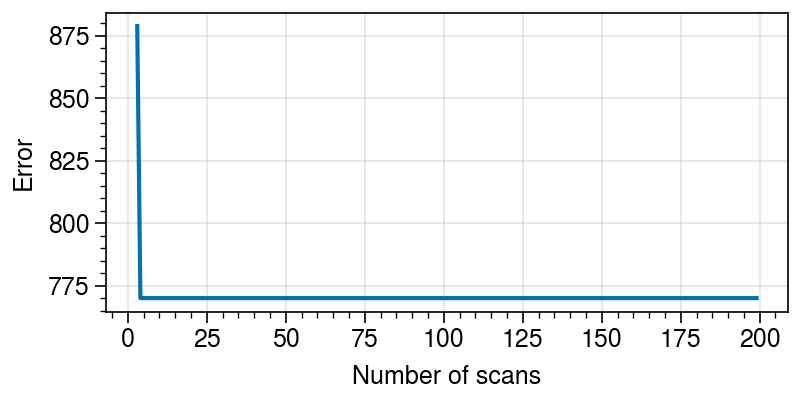

In [20]:
fig, ax = plot.subplots(figsize=(4, 2))
ax.plot(nscans_arr, errors)
ax.format(ylabel='Error', xlabel='Number of scans')